# CSU EDA v0.2

## Boilerplate

- 2022-01-01 to present (starts on a saturday)
- DMA split 3 ways:
    - awareness_markets: Orlando, Jacksonville, Greenville, SC and Birmingham
    - Mobile (DMA)
    - all other DMA
- it's been decided to only use cohort view (KPI by Lead date)
- Media Data (set up by Mike for Geo): Bing, Google, Meta, TikTok, TTD, LinkedIn
    - what to do with linkedIn since it has no geo info???

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [2]:
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

## Process data

### Process KPIs

In [37]:
kpi_raw

,leaddate,appdate,enrolldate,n_lead,n_app,n_enroll,dw_vendor,dw_channel,dmaname
0,2022-01-01 00:10:13,NaN,NaN,1,0,0,GoogleNonBrand,Search,PHILADELPHIA
1,2022-01-01 00:39:04,2023-05-08 15:25:00,2023-05-25 08:07:00,1,1,1,GoogleNonBrand,Search,LOS ANGELES
2,2022-01-01 00:50:52,NaN,NaN,1,0,0,GoogleBrand,Search,RALEIGH-DURHAM (FAYETVLLE)
3,2022-01-01 02:20:25,NaN,NaN,1,0,0,Facebook,Social,ANCHORAGE
4,2022-01-01 02:22:06,NaN,NaN,0,0,0,Facebook,Social,ANCHORAGE
...,...,...,...,...,...,...,...,...,...
277819,2025-01-15 08:53:31,NaN,NaN,1,0,0,GoogleNonBrand,Search,"PORTLAND, OR"
277820,2025-01-15 08:54:39,NaN,NaN,1,0,0,GoogleBrand,Search,"JACKSON, MS"
277821,2025-01-15 08:56:26,NaN,NaN,1,0,0,GoogleBrand,Search,LOS ANGELES
277822,2025-01-15 08:57:11,NaN,NaN,1,0,0,GoogleBrand,Search,NEW YORK


In [56]:
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()
df_kpi_full['dma'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'dma'] = 'mobile'
df_kpi_full.loc[df_kpi_full['dma'].isna(), 'dma'] = 'other'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 
df_kpi_full['channel'] = None
# df_kpi_full.loc[df_kpi_full['dw_vendor'] == 'ArcherOrg', 'channel'] = 'Organic'
# df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('Referral'), 'channel'] = 'Referral'
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-13'] ## Made this Mon-Sun for week

### Making cohort KPI data frame where all KPI are by the lead date (drop organic being separated, roll into ALL with referral)
df_kpi_cohort = df_kpi_full.loc[df_kpi_full.dma != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.groupby(['leaddate', 'dma', 'channel'])[['n_lead', 'n_app', 'n_enroll']].agg('sum')
df_kpi_cohort = df_kpi_cohort.unstack(['dma', 'channel']).reorder_levels([1,2, 0], axis=1).sort_index(axis=1).fillna(0)

df_kpi_cohort_weekly = df_kpi_cohort.resample('W-Mon').sum()

df_kpi_cohort_monthly = df_kpi_cohort.resample('MS').sum()

C:\Users\ktaljan\AppData\Local\Temp\ipykernel_12912\456350975.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'


In [57]:
df_kpi_full.groupby(['dw_channel']).agg(
    n_lead=('n_lead','sum'),
    n_app=('n_app','sum'),
    n_enroll=('n_enroll','sum'),
).sort_values('n_enroll', ascending=False)

,n_lead,n_app,n_enroll
dw_channel,,,
Search,92973,26968,10549
Referral,7101,3192,1709
SEO,9986,3318,1419
PPL,35380,5452,908
Outreach,17279,2138,838
Other,4962,869,380
Social,37573,2454,358
Chat,2025,566,347
Display,13645,1270,151


In [58]:
df_kpi_full

,leaddate,appdate,enrolldate,n_lead,n_app,n_enroll,dw_vendor,dw_channel,dma,channel
0,2022-01-01,NaT,NaT,1,0,0,GoogleNonBrand,Search,other,"ALL(No PPL,Referral)"
1,2022-01-01,2023-05-08,2023-05-25,1,1,1,GoogleNonBrand,Search,other,"ALL(No PPL,Referral)"
2,2022-01-01,NaT,NaT,1,0,0,GoogleBrand,Search,other,"ALL(No PPL,Referral)"
3,2022-01-01,NaT,NaT,1,0,0,Facebook,Social,other,"ALL(No PPL,Referral)"
4,2022-01-01,NaT,NaT,0,0,0,Facebook,Social,other,"ALL(No PPL,Referral)"
...,...,...,...,...,...,...,...,...,...,...
276678,2025-01-12,NaT,NaT,0,0,0,HL,PPL,other,PPL
276679,2025-01-12,NaT,NaT,1,0,0,HL,PPL,other,PPL
276680,2025-01-12,NaT,NaT,1,0,0,HL,PPL,other,PPL
276681,2025-01-12,NaT,NaT,1,0,0,HL,PPL,other,PPL


In [59]:
df_kpi_cohort_monthly.tail()

dma                   awareness                                        \
channel    ALL(No PPL,Referral)                   PPL                   
                          n_app n_enroll n_lead n_app n_enroll n_lead   
leaddate                                                                
2024-09-01                41.00    11.00 224.00  6.00     1.00  28.00   
2024-10-01                40.00    14.00 187.00  5.00     2.00  32.00   
2024-11-01                38.00    11.00 244.00  7.00     1.00  46.00   
2024-12-01                27.00     2.00 252.00  2.00     0.00  36.00   
2025-01-01                20.00     1.00 132.00  5.00     0.00  23.00   

dma                       other                                             
channel    ALL(No PPL,Referral)                      PPL                    
                          n_app n_enroll   n_lead  n_app n_enroll   n_lead  
leaddate                                                                    
2024-09-01             1,016.00   391.00 6,569.00 135.00    19.00   870.00  
2024-10-01               977.00   335.00 6,308.00 134.00    21.00   847.00  
2024-11-01             1,004.00   236.00 6,775.00 196.00    15.00   981.00  
2024-12-01               918.00   103.00 6,593.00 164.00     9.00 1,049.00  
2025-01-01               368.00    27.00 3,243.00  87.00     2.00   732.00

### Process google

In [61]:
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']

df_goo = google_raw.copy()
df_goo['Date'] = pd.to_datetime(df_goo['Date'])
df_goo['Metro area'] = df_goo['Metro area'].str.upper()
df_goo['dma'] = None
df_goo.loc[df_goo['Metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_goo.loc[df_goo['Metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_goo.loc[df_goo['dma'].isna(), 'dma'] = 'other'
df_goo = df_goo.loc[df_goo.dma != 'mobile']
df_goo['channel'] = None
df_goo.loc[df_goo['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_goo.loc[df_goo['Campaign name'].str.contains('YouTube'), 'channel'] = 'YouTube'
df_goo.loc[df_goo['Campaign name'].str.contains('Display'), 'channel'] = 'Display'
df_goo.loc[df_goo['channel'].isna(), 'channel'] = 'SearchNonBrand' ###not certain if this is what we can make nonBrand
df_goo = df_goo.rename(columns={'Cost':'spend', 'Date':'date'})
df_goo = df_goo[['date', 'dma', 'channel', 'spend']]

In [62]:
df_goo

,date,dma,channel,spend
0,2022-07-01,other,SearchNonBrand,43.53
1,2022-07-02,other,SearchNonBrand,4.64
2,2022-07-02,other,SearchNonBrand,9.23
3,2022-07-02,other,SearchNonBrand,29.98
4,2022-07-03,other,SearchNonBrand,84.27
...,...,...,...,...
2464861,2022-06-28,other,Display,0.00
2464862,2022-06-29,other,Display,0.00
2464863,2022-06-30,other,Display,0.00
2464864,2022-06-30,other,Display,0.00


### Process Bing

In [63]:
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM']

df_bing = bing_raw.copy()
df_bing['Date'] = pd.to_datetime(df_bing['Date'])
df_bing['Visitor metro area'] = df_bing['Visitor metro area'].str.upper()
df_bing['dma'] = None
df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_bing.loc[df_bing['Visitor metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_bing = df_bing.loc[df_bing.dma != 'mobile']
df_bing.loc[df_bing['dma'].isna(), 'dma'] = 'other'
df_bing['channel'] = None
df_bing.loc[df_bing['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_bing.loc[df_bing['Brand'] == 'Non Brand', 'channel'] = 'SearchNonBrand'
df_bing = df_bing.rename(columns={'Cost':'spend', 'Date':'date'})
df_bing = df_bing.groupby(['date', 'dma', 'channel'])['spend'].agg('sum').reset_index()

In [64]:
df_bing

,date,dma,channel,spend
0,2022-01-14,awareness,SearchBrand,91.48
1,2022-01-14,awareness,SearchNonBrand,13.86
2,2022-01-14,other,SearchBrand,"1,206.78"
3,2022-01-14,other,SearchNonBrand,319.97
4,2022-01-15,awareness,SearchBrand,36.33
...,...,...,...,...
4327,2024-12-30,other,SearchNonBrand,"2,147.94"
4328,2024-12-31,awareness,SearchBrand,77.26
4329,2024-12-31,awareness,SearchNonBrand,161.03
4330,2024-12-31,other,SearchBrand,"1,109.15"


### Process TikTok

In [65]:
list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']

df_tiktok = tiktok_raw.copy()
df_tiktok['Date'] = pd.to_datetime(df_tiktok['Date'])
df_tiktok['DMA name'] = df_tiktok['DMA name'].str.upper()
df_tiktok['dma'] = None
df_tiktok.loc[df_tiktok['DMA name'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_tiktok.loc[df_tiktok['DMA name'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_tiktok = df_tiktok.loc[df_tiktok.dma != 'mobile']
df_tiktok.loc[df_tiktok['dma'].isna(), 'dma'] = 'other'
df_tiktok['channel'] = 'TikTok'
df_tiktok = df_tiktok.rename(columns={'Cost':'spend', 'Date':'date'})
df_tiktok = df_tiktok[['date', 'dma', 'channel', 'spend']]

In [66]:
df_tiktok

,date,dma,channel,spend
0,2024-02-03,other,TikTok,7.00
1,2024-02-21,other,TikTok,7.00
2,2024-02-24,other,TikTok,7.00
3,2024-02-05,other,TikTok,7.25
4,2024-04-15,other,TikTok,7.50
...,...,...,...,...
335089,2023-11-23,other,TikTok,1.81
335090,2023-11-30,other,TikTok,1.81
335091,2023-12-03,other,TikTok,1.81
335092,2023-12-17,other,TikTok,1.81


### Process Meta

In [67]:
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']

df_meta = meta_raw.copy()
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_meta['DMA'] = df_meta['DMA'].str.upper()
df_meta['dma'] = None
df_meta.loc[df_meta['DMA'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_meta.loc[df_meta['DMA'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_meta = df_meta.loc[df_meta.dma != 'mobile']
df_meta.loc[df_meta['dma'].isna(), 'dma'] = 'other'
df_meta['channel'] = 'Meta'
df_meta = df_meta.rename(columns={'Cost':'spend', 'Date':'date'})
df_meta = df_meta[['date', 'dma', 'channel', 'spend']]

In [68]:
df_meta

,date,dma,channel,spend
0,2022-07-01,other,Meta,0.65
1,2022-07-01,other,Meta,1.53
2,2022-07-01,other,Meta,0.69
3,2022-07-01,awareness,Meta,3.55
4,2022-07-02,other,Meta,1.22
...,...,...,...,...
1733750,2024-08-25,other,Meta,0.07
1733751,2024-10-23,other,Meta,0.14
1733752,2024-12-29,other,Meta,0.14
1733753,2024-11-17,other,Meta,0.14


### Process TTD

In [69]:
list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']

df_ttd = ttd_raw.copy()
df_ttd['record_date'] = pd.to_datetime(df_ttd['record_date'])
df_ttd['metro'] = df_ttd['metro'].str.upper()
df_ttd['dma'] = None
df_ttd.loc[df_ttd['metro'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_ttd.loc[df_ttd['metro'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_ttd = df_ttd.loc[df_ttd.dma != 'mobile']
df_ttd.loc[df_ttd['dma'].isna(), 'dma'] = 'other'
df_ttd.loc[df_ttd['campaign_name'].str.contains('DOOH'), 'channel'] = 'DOOH'
df_ttd.loc[df_ttd['campaign_name'].str.contains('|'.join(['CTV', 'OTT'])), 'channel'] = 'CTV/OTT'
df_ttd.loc[df_ttd['campaign_name'].str.contains('Audio'), 'channel'] = 'Digital Radio'
df_ttd = df_ttd.rename(columns={'cost':'spend', 'record_date':'date'})
df_ttd = df_ttd[['date', 'dma', 'channel', 'spend']]

In [70]:
df_ttd

,date,dma,channel,spend
0,2024-06-24,awareness,DOOH,"1,769.11"
1,2024-06-25,awareness,DOOH,"1,269.76"
2,2024-06-26,awareness,DOOH,"1,326.08"
3,2024-06-27,awareness,DOOH,"1,357.42"
4,2024-06-28,awareness,DOOH,"1,414.66"
...,...,...,...,...
10423,2024-09-12,awareness,CTV/OTT,0.00
10424,2024-09-13,awareness,CTV/OTT,0.00
10425,2024-09-14,awareness,CTV/OTT,0.00
10426,2024-09-15,awareness,CTV/OTT,0.00


### Process LinkedIn

In [71]:
 ### LinkedIn has no geo splitting from platform
df_li = linkedin_raw.copy()
df_li = df_li.rename(columns={'record_date':'date', 'cost':'spend'})
df_li['date'] = pd.to_datetime(df_li['date'])
df_li = df_li.groupby('date')['spend'].agg('sum').reset_index()
df_li['channel'] = 'LinkedIn'
df_li['dma'] = 'unknown'

In [72]:
df_li

,date,spend,channel,dma
0,2023-10-26,248.97,LinkedIn,unknown
1,2023-10-27,251.49,LinkedIn,unknown
2,2023-10-28,251.25,LinkedIn,unknown
3,2023-10-29,250.15,LinkedIn,unknown
4,2023-10-30,250.13,LinkedIn,unknown
...,...,...,...,...
443,2025-01-11,743.54,LinkedIn,unknown
444,2025-01-12,620.89,LinkedIn,unknown
445,2025-01-13,888.96,LinkedIn,unknown
446,2025-01-14,"1,227.14",LinkedIn,unknown


### Other Spend Wrangling

In [73]:
df_spend = pd.concat([df_bing, df_goo, df_meta, df_tiktok, df_ttd, df_li])
df_spend = df_spend.groupby(['date', 'dma', 'channel'])['spend'].agg('sum')
df_spend_daily = df_spend.reset_index().copy()

df_spend_weekly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_weekly = df_spend_weekly.resample('W-Sat').sum()

df_spend_monthly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_monthly = df_spend_monthly.resample('MS').sum()

In [19]:
# today = pd.Timestamp.today().date()
# today = pd.to_datetime(today).strftime('%Y-%m-%d')

# ### saving different df's to a single sheet
# with pd.ExcelWriter(f'../data/csu_final_data_{today}.xlsx') as writer:
#     df_kpi_full.to_excel(writer, sheet_name='KPI_full', index=True, merge_cells=True)
#     df_kpi_cohort.to_excel(writer, sheet_name='KPI_cohort_daily', index=True, merge_cells=True)
#     df_kpi_cohort_weekly.to_excel(writer, sheet_name='KPI_cohort_weekly', index=True, merge_cells=True)
#     df_kpi_cohort_monthly.to_excel(writer, sheet_name='KPI_cohort_monthly', index=True, merge_cells=True)
#     df_spend_daily.to_excel(writer, sheet_name='spend_daily', index=True, merge_cells=True)  
#     df_spend_weekly.to_excel(writer, sheet_name='spend_weekly', index=True, merge_cells=True)
#     df_spend_monthly.to_excel(writer, sheet_name='spend_monthly', index=True, merge_cells=True)              

## EDA

In [25]:
# df_kpi_full[['n_lead', 'n_app', 'n_enroll']].sum()

In [26]:
# df_kpi_full.groupby('dma')[['n_lead', 'n_app', 'n_enroll']].sum()

In [27]:
# df_kpi_full.groupby(['dma', 'channel'])[['n_lead', 'n_app', 'n_enroll']].sum()

In [28]:
# df_spend_daily.groupby('dma')['spend'].sum() #unknown is LinkedIn only

In [29]:
# df_spend_daily.groupby(['dma', 'channel'])['spend'].sum()

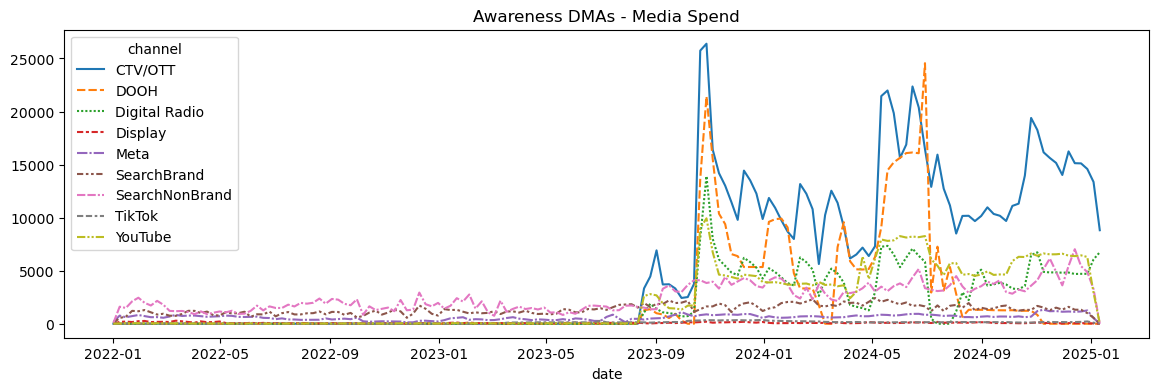

In [74]:
fig, axes = plt.subplots(1,1, figsize=(14,4), sharex=True)

df_gr = df_spend_weekly.loc[:,'awareness'][:-1]
# plt.figure(figsize=(16,6))
axes.set_title('Awareness DMAs - Media Spend')

sns.lineplot(data=df_gr)

plt.savefig('../data/Media_AwarenessDMAs_CSU_2025-01-24.png') 

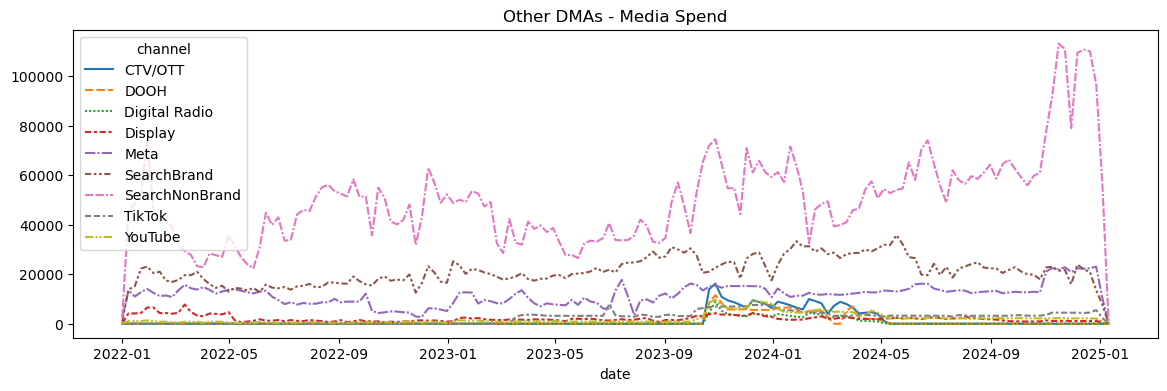

In [75]:
fig, axes = plt.subplots(1,1, figsize=(14,4), sharex=True)

df_gr = df_spend_weekly.loc[:,'other'][:-1]
# plt.figure(figsize=(16,6))
axes.set_title('Other DMAs - Media Spend')

sns.lineplot(data=df_gr)
plt.savefig('../data/Media_OtherDMAs_CSU_2025-01-24.png') 

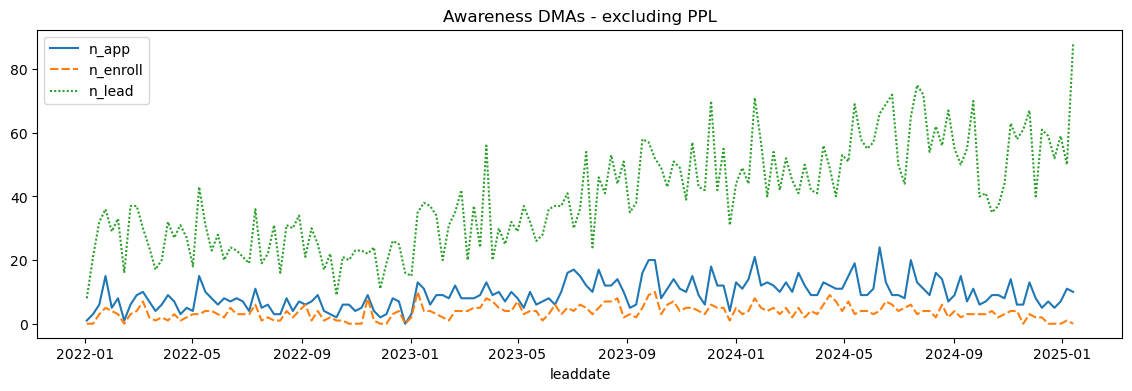

In [76]:
fig, axes = plt.subplots(1,1, figsize=(14,4), sharex=True)
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('awareness', 'ALL(No PPL,Referral)')], ax=axes)
# sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('awareness', 'PPL')], ax=axes[1])
axes.set_title('Awareness DMAs - excluding PPL')
# axes[1].set_title('Awareness DMAs - PPL Only');

plt.savefig('../data/KPIs_AwarenessDMAs_CSU_2025-01-24.png') 

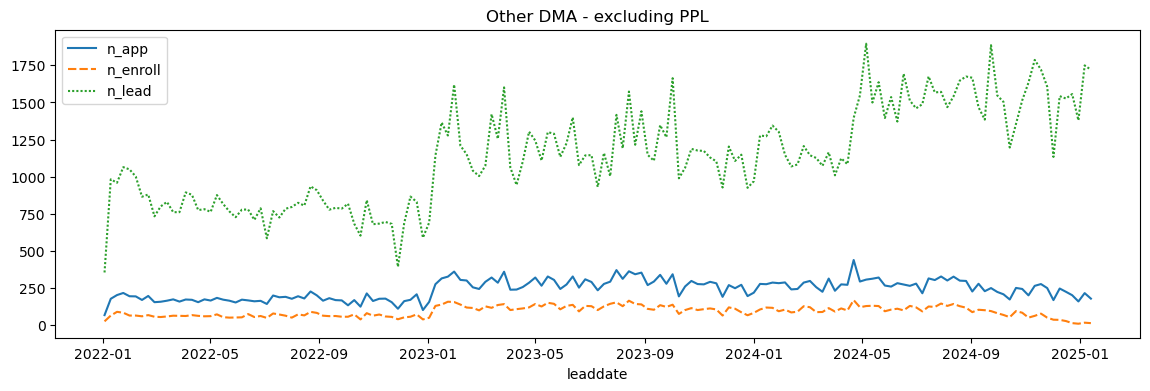

In [77]:
# fig, axes = plt.subplots(2,1, figsize=(14,6), sharex=True)
fig, axes = plt.subplots(1,1, figsize=(14,4), sharex=True)
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('other', 'ALL(No PPL,Referral)')], ax=axes)
# sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('other', 'PPL')], ax=axes[1])
axes.set_title('Other DMA - excluding PPL')
# axes[1].set_title('Other DMA - PPL Only');

plt.savefig('../data/KPIs_otherDMAs_CSU_2025-01-24.png') 